In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers



/Users/user/repos/tbilisi_home_price_prediction_model/pricing_model/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%matplotlib inline


In [3]:
path_to_csv = "../data/housing_data.csv"
image_dir = "../data/images" 
column_names = ["id", "url", "imageurl", "header", "price", "sqmprice", "sqm", "floor", "rooms", "bedrooms", "address"]


In [4]:
df = pd.read_csv(path_to_csv, names=column_names, header=None)
image_files = set(os.listdir(image_dir))
valid_ids = {int(filename.split('.')[0]) for filename in image_files if filename.split('.')[0].isdigit()}
df = df[df.iloc[:, 0].isin(valid_ids)]
df = df.dropna() # We lost 5% of the data, problem seems to be with the method of scraping or the website error itself
df.drop(['url', 'imageurl'], axis=1, inplace=True)

In [5]:
def modify_address(addr):
    # Split the address string by comma and retain everything after the first comma
    parts = addr.split(',', 1)  # Split only at the first comma
    return parts[1].strip() if len(parts) > 1 else addr

In [6]:
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

# Filter the dataframe using the mask
df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)

mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() > 40].index)

df = df[mask]

In [7]:
df["address"].value_counts()

address
დიდი დიღომი, საბურთალოს რაიონი, თბილისი                                  1819
საბურთალო, საბურთალოს რაიონი, თბილისი                                    1696
ა. პოლიტკოვსკაიას ქუჩა (ჯიქია), საბურთალო, საბურთალოს რაიონი, თბილისი    1690
ი. ჭავჭავაძის გამზირი, ვაკე, ვაკის რაიონი, თბილისი                       1201
ვაკე, ვაკის რაიონი, თბილისი                                               986
                                                                         ... 
მ. ბუხაიძის ქუჩა, ვორონცოვი, ჩუღურეთის რაიონი, თბილისი                     42
ლიბანის ქუჩა, ავჭალა, გლდანის რაიონი, თბილისი                              41
მეტრომშენი, ისნის რაიონი, თბილისი                                          41
ზ. საკანდელიძის ქუჩა, ბაგები, ვაკის რაიონი, თბილისი                        41
როსტევანის ქუჩა, დიდი დიღომი, საბურთალოს რაიონი, თბილისი                   41
Name: count, Length: 278, dtype: int64

In [8]:
df['status'] = df['header'].str.split().str.get(1)
df['location_name'] = df['header'].str.replace("იყიდება ახალი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება ძველი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება მშენებარე ბინა ", "", regex=False).str.strip()

value_counts = df['location_name'].value_counts()
print(value_counts)
# Keep only rows where the 'location_name' value count is >= 30
df = df[df['location_name'].isin(value_counts[value_counts >= 30].index)]
df.drop(['header'], axis=1, inplace=True)


location_name
საბურთალოზე        11562
ვაკეში              4867
დიდ დიღომში         3386
დიდუბეში            2400
გლდანის მასივში     2272
                   ...  
კვესეთში               1
ვარდისუბანში           1
ბეთანიაში              1
ხარფუხში               1
ახალდაბაში             1
Name: count, Length: 122, dtype: int64


In [9]:
df["price"] = df["price"].str.replace(",", "").astype(float)
df["sqm"] = df["sqm"].str.replace(" მ²", "").astype(float)
df["floor"] = df["floor"].str.replace("სარ.", "").astype(float)
df["rooms"] = df["rooms"].str.replace("ოთ.", "").astype(float)
df["bedrooms"] = df["bedrooms"].str.replace("საძ.", "").astype(float)
df.drop("sqmprice", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)



In [10]:
df.sort_values(by='price', ascending=True)

,price,sqm,floor,rooms,bedrooms,address,status,location_name
12625,12800.0,44.9,12.0,2.0,1.0,"მირიან მეფის ქუჩა, დიდი დიღომი, საბურთალოს რაი...",მშენებარე,დიდ დიღომში
22055,13000.0,13.0,1.0,1.0,1.0,"ვაჟა-ფშაველას კვარტალები, საბურთალო, საბურთალო...",ახალი,ვაჟა-ფშაველას კვარტალებში
40403,14000.0,34.0,1.0,3.0,1.0,"გლდანი 1 მკრ., გლდანის მასივი, გლდანის რაიონი,...",ახალი,გლდანი 1 მკრ. რაიონში
52772,14500.0,43.2,2.0,2.0,1.0,"მირიან მეფის ქუჩა, დიდი დიღომი, საბურთალოს რაი...",მშენებარე,დიდ დიღომში
16714,15000.0,8.9,1.0,1.0,1.0,"სოლოლაკი, მთაწმინდის რაიონი, თბილისი",ძველი,სოლოლაკში
...,...,...,...,...,...,...,...,...
16671,13950000.0,90.0,1.0,3.0,2.0,"საბურთალო, საბურთალოს რაიონი, თბილისი",ახალი,საბურთალოზე
3467,16200000.0,108.0,2.0,3.0,2.0,"ა. პოლიტკოვსკაიას ქუჩა (ჯიქია), საბურთალო, საბ...",ახალი,საბურთალოზე
18797,32400000.0,120.0,4.0,3.0,2.0,"ვაკე, ვაკის რაიონი, თბილისი",ახალი,ვაკეში
15287,100000000.0,251.0,2.0,7.0,5.0,"ვერა, მთაწმინდის რაიონი, თბილისი",ძველი,ვერაზე


In [11]:
df = df[df["price"] <= 500000]
df = df[df["price"] >= 10000]


In [12]:
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()
df[['sqm', 'floor', 'rooms', 'bedrooms']] = scaler.fit_transform(df[['sqm', 'floor', 'rooms', 'bedrooms']])
df[['price']] = price_scaler.fit_transform(df[['price']])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['location_name', "status", "address"])

bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)
# Split the data into training and test sets
y = df['price']
X = df.drop('price', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# Model definition

model = Sequential([
    layers.Dense(1024, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],),),
    layers.BatchNormalization(),

    layers.Dense(512, activation='relu', kernel_initializer='he_normal',  ),
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu', kernel_initializer='he_normal',  ),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu', kernel_initializer='he_normal',  ),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu', kernel_initializer='he_normal',  ),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', ),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu', kernel_initializer='he_normal',  ),
    
    layers.Dense(1)
    ]
)



In [14]:
model.compile(optimizer=keras.optimizers.legacy.Adam(0.001), loss='mean_squared_error',  metrics=['mean_absolute_error'])

In [15]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_dev, y_dev))

Epoch 1/300
1316/1316 [==============================] - 13s 9ms/step - loss: 0.0623 - mean_absolute_error: 0.1606 - val_loss: 0.0200 - val_mean_absolute_error: 0.1067
Epoch 2/300
1316/1316 [==============================] - 9s 7ms/step - loss: 0.0140 - mean_absolute_error: 0.0863 - val_loss: 0.0112 - val_mean_absolute_error: 0.0771
Epoch 3/300
1316/1316 [==============================] - 11s 9ms/step - loss: 0.0114 - mean_absolute_error: 0.0763 - val_loss: 0.0123 - val_mean_absolute_error: 0.0813
Epoch 4/300
1316/1316 [==============================] - 11s 9ms/step - loss: 0.0098 - mean_absolute_error: 0.0693 - val_loss: 0.0087 - val_mean_absolute_error: 0.0626
Epoch 5/300
1316/1316 [==============================] - 9s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0658 - val_loss: 0.0152 - val_mean_absolute_error: 0.0896
Epoch 6/300
1316/1316 [==============================] - 9s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0618 - val_loss: 0.0081 - val_mean_absolute_error: 0.

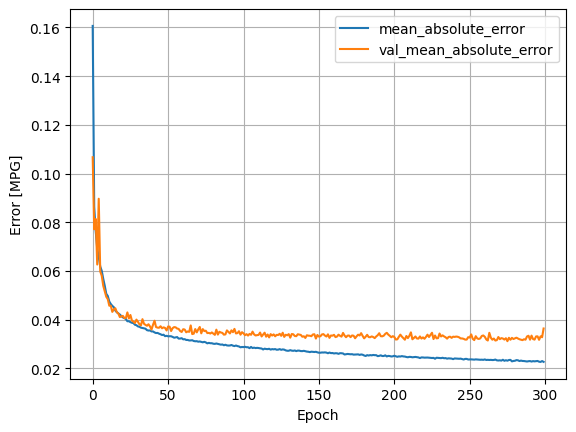

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [17]:
loss, mae = model.evaluate(X_dev, y_dev)
train_loss, train_mae = model.evaluate(X_train, y_train)

print(f"Test Loss: {loss}")
scaled_mae = mae
scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {original_mae[0]}")
print(f"Original train MAE: {original_train_mae[0]}")

1316/1316 [==============================] - 2s 2ms/step - loss: 0.7539 - mean_absolute_error: 0.0365
Test Loss: 0.012239549309015274
Original MAE: 17707.139441370964
Original train MAE: 17782.18628168106


In [18]:
# 1. Predict on test data
y_pred = model.predict(X_dev)

# Inverse transform the scaled target variable (y_dev)
y_dev_actual = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))

# Inverse transform the scaled predictions (y_pred)
y_pred_actual = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

print(y_dev_actual.shape)
print(y_pred_actual.shape)

# 2. Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': y_dev_actual.flatten(),
    'Predicted Values': y_pred_actual.flatten() # flatten is used to convert the 2D array to 1D
})

print(comparison_df)


165/165 [==============================] - 0s 2ms/step
(5260, 1)
(5260, 1)
      Actual Values  Predicted Values
0           61000.0      58573.488281
1           52000.0      51399.687500
2           90000.0      96133.773438
3           44000.0      36274.820312
4          198000.0     181783.234375
...             ...               ...
5255        48500.0      63006.953125
5256        50500.0      53066.886719
5257        61100.0      65505.894531
5258       360000.0     260329.187500
5259       334800.0     190108.468750

[5260 rows x 2 columns]


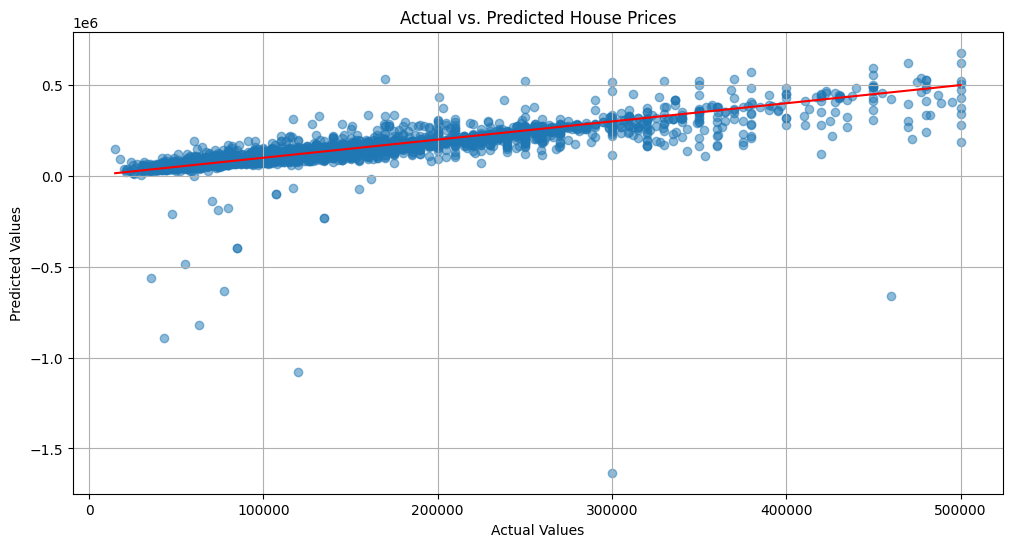

In [19]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(comparison_df['Actual Values'], comparison_df['Predicted Values'], alpha=0.5)
plt.plot([min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         [min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         color='red')  # Diagonal line

plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [20]:
y_pred_test = model.predict(X_dev)
y_dev_actual_for_r2 = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))
y_pred_actual_for_r2 = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Calculate the R^2 score
r2 = r2_score(y_dev_actual_for_r2, y_pred_actual_for_r2)
r2

165/165 [==============================] - 0s 2ms/step


0.5387261321365626